### В данном ноутбуке попробуем построить модель для классификации изображений с сайта https://quickdraw.withgoogle.com/. Данные взяты с формате .npy и представляют из себя 784 пикселя(Ниже примеры). Для моделирования будем использовать библиотеку tensorflow и keras, catboost, 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from os import walk
import re
from tqdm import tqdm
import uuid

df = pd.read_csv('F:\\doodles\\bucket_31.csv')
df.drop(columns=['Unnamed: 0'], inplace= True)


In [3]:
df.groupby('category').count()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
category,,,,,,,,,,,,,,,,,,,,,
airplane,607,607,607,607,607,607,607,607,607,607,...,607,607,607,607,607,607,607,607,607,607
ambulance,592,592,592,592,592,592,592,592,592,592,...,592,592,592,592,592,592,592,592,592,592
angel,599,599,599,599,599,599,599,599,599,599,...,599,599,599,599,599,599,599,599,599,599
ant,499,499,499,499,499,499,499,499,499,499,...,499,499,499,499,499,499,499,499,499,499
anvil,505,505,505,505,505,505,505,505,505,505,...,505,505,505,505,505,505,505,505,505,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
windmill,483,483,483,483,483,483,483,483,483,483,...,483,483,483,483,483,483,483,483,483,483
wristwatch,651,651,651,651,651,651,651,651,651,651,...,651,651,651,651,651,651,651,651,651,651
yoga,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,...,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122


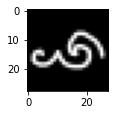

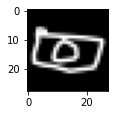

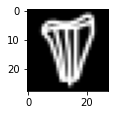

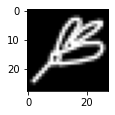

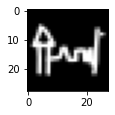

In [4]:
categories = []
for i in range(5):
    sample = df.sample(1)
    pixels = sample.drop(columns=['category']).values.reshape((28, 28))
    categories.append(sample['category'].values[0])
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [5]:
categories

['moustache', 'camera', 'harp', 'mosquito', 'castle']

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(df['category'])
df["category_enc"] = le.transform(df['category'])
y = df['category_enc']
to_drop = ['category', 'category_enc']
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=to_drop), y, test_size=0.3,random_state=42)

In [ ]:
from catboost import CatBoostClassifier

clf_cat = CatBoostClassifier(task_type='GPU', max_depth=5)
clf_cat.fit(X_train, y_train)

Learning rate set to 0.216164
0:	learn: 5.3450042	total: 2.5s	remaining: 41m 32s
1:	learn: 5.1265753	total: 5.05s	remaining: 42m 1s
2:	learn: 4.9418775	total: 7.51s	remaining: 41m 34s
3:	learn: 4.8004240	total: 10.1s	remaining: 42m 4s
4:	learn: 4.6884164	total: 12.7s	remaining: 42m 2s
5:	learn: 4.5980428	total: 14.9s	remaining: 41m 13s
6:	learn: 4.4999708	total: 17.5s	remaining: 41m 24s
7:	learn: 4.4248363	total: 19.9s	remaining: 41m 7s
8:	learn: 4.3535911	total: 22.4s	remaining: 41m 4s
9:	learn: 4.2906769	total: 24.6s	remaining: 40m 39s
10:	learn: 4.2282100	total: 27.1s	remaining: 40m 40s
11:	learn: 4.1724970	total: 29.6s	remaining: 40m 35s
12:	learn: 4.1109044	total: 32s	remaining: 40m 32s
13:	learn: 4.0682544	total: 34.3s	remaining: 40m 18s
14:	learn: 4.0158360	total: 36.9s	remaining: 40m 26s
15:	learn: 3.9688694	total: 39.6s	remaining: 40m 33s
16:	learn: 3.9325557	total: 41.8s	remaining: 40m 17s
17:	learn: 3.8894705	total: 44.4s	remaining: 40m 19s
18:	learn: 3.8500454	total: 46.7s	

153:	learn: 2.4468290	total: 5m 46s	remaining: 31m 40s
154:	learn: 2.4434368	total: 5m 48s	remaining: 31m 37s
155:	learn: 2.4402391	total: 5m 50s	remaining: 31m 34s
156:	learn: 2.4367021	total: 5m 52s	remaining: 31m 31s
157:	learn: 2.4336849	total: 5m 54s	remaining: 31m 28s
158:	learn: 2.4294583	total: 5m 56s	remaining: 31m 25s
159:	learn: 2.4276020	total: 5m 58s	remaining: 31m 21s
160:	learn: 2.4258545	total: 6m	remaining: 31m 18s
161:	learn: 2.4254221	total: 6m 2s	remaining: 31m 14s
162:	learn: 2.4215245	total: 6m 4s	remaining: 31m 11s
163:	learn: 2.4197795	total: 6m 6s	remaining: 31m 7s
164:	learn: 2.4180425	total: 6m 8s	remaining: 31m 4s
165:	learn: 2.4171356	total: 6m 10s	remaining: 31m
166:	learn: 2.4131759	total: 6m 12s	remaining: 30m 58s
167:	learn: 2.4096908	total: 6m 14s	remaining: 30m 55s
168:	learn: 2.4068832	total: 6m 16s	remaining: 30m 52s
169:	learn: 2.4050663	total: 6m 18s	remaining: 30m 48s
170:	learn: 2.3991130	total: 6m 20s	remaining: 30m 46s
171:	learn: 2.3958288	to

303:	learn: 2.1723547	total: 10m 44s	remaining: 24m 36s
304:	learn: 2.1717255	total: 10m 46s	remaining: 24m 33s
305:	learn: 2.1702777	total: 10m 48s	remaining: 24m 31s
306:	learn: 2.1681402	total: 10m 50s	remaining: 24m 28s
307:	learn: 2.1669767	total: 10m 52s	remaining: 24m 26s
308:	learn: 2.1620582	total: 10m 55s	remaining: 24m 24s
309:	learn: 2.1606441	total: 10m 57s	remaining: 24m 22s
310:	learn: 2.1602353	total: 10m 58s	remaining: 24m 19s
311:	learn: 2.1600749	total: 11m	remaining: 24m 17s
312:	learn: 2.1594541	total: 11m 2s	remaining: 24m 14s
313:	learn: 2.1580661	total: 11m 4s	remaining: 24m 12s
314:	learn: 2.1547440	total: 11m 6s	remaining: 24m 10s
315:	learn: 2.1539761	total: 11m 8s	remaining: 24m 7s
316:	learn: 2.1538076	total: 11m 10s	remaining: 24m 4s
317:	learn: 2.1530077	total: 11m 12s	remaining: 24m 2s
318:	learn: 2.1522574	total: 11m 14s	remaining: 23m 59s
319:	learn: 2.1515665	total: 11m 16s	remaining: 23m 57s
320:	learn: 2.1511199	total: 11m 18s	remaining: 23m 54s
321

451:	learn: 2.0009613	total: 15m 37s	remaining: 18m 56s
452:	learn: 2.0003534	total: 15m 39s	remaining: 18m 54s
453:	learn: 1.9983487	total: 15m 41s	remaining: 18m 51s
454:	learn: 1.9976963	total: 15m 43s	remaining: 18m 49s
455:	learn: 1.9972642	total: 15m 45s	remaining: 18m 47s
456:	learn: 1.9953062	total: 15m 47s	remaining: 18m 45s
457:	learn: 1.9945105	total: 15m 49s	remaining: 18m 43s
458:	learn: 1.9916231	total: 15m 51s	remaining: 18m 41s
459:	learn: 1.9908262	total: 15m 53s	remaining: 18m 38s
460:	learn: 1.9905287	total: 15m 55s	remaining: 18m 36s
461:	learn: 1.9899994	total: 15m 56s	remaining: 18m 34s
462:	learn: 1.9895163	total: 15m 58s	remaining: 18m 32s
463:	learn: 1.9881394	total: 16m	remaining: 18m 29s
464:	learn: 1.9863881	total: 16m 2s	remaining: 18m 27s
465:	learn: 1.9857451	total: 16m 4s	remaining: 18m 25s
466:	learn: 1.9853787	total: 16m 6s	remaining: 18m 23s
467:	learn: 1.9846880	total: 16m 8s	remaining: 18m 20s
468:	learn: 1.9845807	total: 16m 10s	remaining: 18m 18s


599:	learn: 1.8717376	total: 20m 27s	remaining: 13m 38s
600:	learn: 1.8714166	total: 20m 29s	remaining: 13m 36s
601:	learn: 1.8699112	total: 20m 31s	remaining: 13m 34s
602:	learn: 1.8687632	total: 20m 33s	remaining: 13m 32s
603:	learn: 1.8683821	total: 20m 35s	remaining: 13m 30s
604:	learn: 1.8676146	total: 20m 37s	remaining: 13m 27s
605:	learn: 1.8658244	total: 20m 39s	remaining: 13m 25s
606:	learn: 1.8651183	total: 20m 41s	remaining: 13m 23s
607:	learn: 1.8643963	total: 20m 43s	remaining: 13m 21s
608:	learn: 1.8637571	total: 20m 45s	remaining: 13m 19s
609:	learn: 1.8632223	total: 20m 47s	remaining: 13m 17s
610:	learn: 1.8623456	total: 20m 49s	remaining: 13m 15s
611:	learn: 1.8617018	total: 20m 51s	remaining: 13m 13s
612:	learn: 1.8610752	total: 20m 53s	remaining: 13m 11s
613:	learn: 1.8601319	total: 20m 55s	remaining: 13m 9s
614:	learn: 1.8585987	total: 20m 57s	remaining: 13m 7s
615:	learn: 1.8576171	total: 20m 59s	remaining: 13m 4s
616:	learn: 1.8572582	total: 21m 1s	remaining: 13m 

748:	learn: 1.7563494	total: 25m 21s	remaining: 8m 29s
749:	learn: 1.7559027	total: 25m 23s	remaining: 8m 27s
750:	learn: 1.7550139	total: 25m 25s	remaining: 8m 25s
751:	learn: 1.7544031	total: 25m 27s	remaining: 8m 23s
752:	learn: 1.7542030	total: 25m 29s	remaining: 8m 21s
753:	learn: 1.7534962	total: 25m 31s	remaining: 8m 19s
754:	learn: 1.7531447	total: 25m 32s	remaining: 8m 17s
755:	learn: 1.7525711	total: 25m 34s	remaining: 8m 15s
756:	learn: 1.7524156	total: 25m 36s	remaining: 8m 13s
757:	learn: 1.7518842	total: 25m 38s	remaining: 8m 11s
758:	learn: 1.7510562	total: 25m 40s	remaining: 8m 9s
759:	learn: 1.7507379	total: 25m 42s	remaining: 8m 7s
760:	learn: 1.7500342	total: 25m 44s	remaining: 8m 5s
761:	learn: 1.7493583	total: 25m 46s	remaining: 8m 3s
762:	learn: 1.7476956	total: 25m 48s	remaining: 8m 1s
763:	learn: 1.7474931	total: 25m 50s	remaining: 7m 58s
764:	learn: 1.7470839	total: 25m 52s	remaining: 7m 56s
765:	learn: 1.7467348	total: 25m 54s	remaining: 7m 54s
766:	learn: 1.7

899:	learn: 1.6484370	total: 30m 21s	remaining: 3m 22s
900:	learn: 1.6471497	total: 30m 23s	remaining: 3m 20s
901:	learn: 1.6463173	total: 30m 25s	remaining: 3m 18s
902:	learn: 1.6455194	total: 30m 27s	remaining: 3m 16s
903:	learn: 1.6446856	total: 30m 30s	remaining: 3m 14s
904:	learn: 1.6445340	total: 30m 31s	remaining: 3m 12s
905:	learn: 1.6443238	total: 30m 33s	remaining: 3m 10s
906:	learn: 1.6438688	total: 30m 35s	remaining: 3m 8s
907:	learn: 1.6427778	total: 30m 37s	remaining: 3m 6s
908:	learn: 1.6421335	total: 30m 39s	remaining: 3m 4s
909:	learn: 1.6413655	total: 30m 41s	remaining: 3m 2s
910:	learn: 1.6411063	total: 30m 43s	remaining: 3m
911:	learn: 1.6402958	total: 30m 45s	remaining: 2m 58s
912:	learn: 1.6401113	total: 30m 47s	remaining: 2m 56s
913:	learn: 1.6390584	total: 30m 49s	remaining: 2m 54s
914:	learn: 1.6385249	total: 30m 51s	remaining: 2m 52s
915:	learn: 1.6382416	total: 30m 53s	remaining: 2m 49s


In [ ]:
from sklearn.metrics import classification_report

y_pred = [*map(lambda x: np.argmax(x), pred)]
report = pd.DataFrame.from_dict(classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)).T
report

In [7]:
import tensorflow as tf
from tensorflow import keras

tf.config.experimental.set_memory_growth(tf.config.get_visible_devices('GPU')[0], True)
DROP_OUT = 4
KERNEL_SIZE = 3
CATEGORIES = len(df['category'].unique())
model = keras.Sequential([
    keras.layers.Reshape((-1,28,28,1)),
    keras.layers.experimental.preprocessing.Rescaling(scale=1./255.),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
        
    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Flatten(),

    keras.layers.Dense(CATEGORIES * 10, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Dense(CATEGORIES * 30, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Dense(CATEGORIES * 30, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Dense(CATEGORIES, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
file = 'F:\\doodles\\dump\\dump'
model = keras.models.load_model(file)
class_weights = None
reports = []
hists = []

In [9]:
from sklearn.metrics import classification_report
import gc

def free(to_erase):
    for obj in to_erase:
        del(obj)
    gc.collect()
    
def load_val_data(encoder):
    df = pd.read_csv('F:\\doodles\\bucket_249.csv')
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df["category_enc"] = encoder.transform(df['category'])
    y = df['category_enc']
    to_drop = ['category', 'category_enc']
    return (df.drop(columns=to_drop), y)
    
def load_data(i, encoder, pattern ='F:\\doodles\\bucket_{}.csv', test_size = 0.2):
    df = pd.read_csv(pattern.format(str(i)))
    df.drop(columns=['Unnamed: 0'], inplace= True)
    df["category_enc"] = encoder.transform(df['category'])
    y = df['category_enc']
    to_drop = ['category', 'category_enc']
    return train_test_split(df.drop(columns=to_drop), y, test_size=test_size)

def get_report(model, encoder):
    X_test, y_test = load_val_data(le)
    pred = model.predict(X_test)
    y_pred = [*map(lambda x: np.argmax(x), pred)]
    return pd.DataFrame.from_dict(classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)).T

def get_weight(value, mean, max_weight):
    value = mean / value ** 7
    return 1 if value <=1 else max_weight if value >= max_weight else value

def get_weights(model, encoder, max_weight=5, metric='f1-score', report = None):
    if report is None:
        report = get_report(model, encoder)
    mean = report[metric].mean()
    return dict((class_, get_weight(report.loc[[class_]][metric][0], mean, max_weight)) for class_ in encoder.classes_)

In [ ]:
file = 'F:\\doodles\\dump'
for i in tqdm(range(96, 250)):
    try:
        X_train, X_test, y_train, y_test = load_data(i, le)
        hist = model.fit(X_train, y_train,
                         epochs=8,
                         batch_size=350,
                         validation_data=(X_test, y_test))
        
        hists.append(hist)
        
        if i % 10 == 0:
            model.save(file)  
            
        free([X_train, X_test, y_train, y_test])
        
        report = get_report(model, le)  
        reports.append(report)
    except KeyboardInterrupt:
        print("Stopped. Current bucket is {}".format(str(i)))
        break

  0%|          | 0/154 [00:00<?, ?it/s]

Epoch 1/8
397/397 [==============================] - 42s 106ms/step - loss: 1.2101 - accuracy: 0.6956 - val_loss: 1.0171 - val_accuracy: 0.7380
Epoch 2/8
397/397 [==============================] - 42s 106ms/step - loss: 1.1297 - accuracy: 0.7118 - val_loss: 1.0095 - val_accuracy: 0.7411
Epoch 3/8
397/397 [==============================] - 42s 106ms/step - loss: 1.0718 - accuracy: 0.7230 - val_loss: 1.0151 - val_accuracy: 0.7427
Epoch 4/8
397/397 [==============================] - 42s 106ms/step - loss: 1.0224 - accuracy: 0.7327 - val_loss: 1.0246 - val_accuracy: 0.7405
Epoch 5/8
397/397 [==============================] - 42s 106ms/step - loss: 0.9714 - accuracy: 0.7416 - val_loss: 1.0189 - val_accuracy: 0.7424
Epoch 6/8
397/397 [==============================] - 42s 106ms/step - loss: 0.9246 - accuracy: 0.7509 - val_loss: 1.0381 - val_accuracy: 0.7398
Epoch 7/8
397/397 [==============================] - 42s 106ms/step - loss: 0.8772 - accuracy: 0.7610 - val_loss: 1.0573 - val_accuracy:

  1%|          | 1/154 [06:18<16:04:28, 378.22s/it]

Epoch 1/8
397/397 [==============================] - 42s 106ms/step - loss: 1.2674 - accuracy: 0.6875 - val_loss: 1.0151 - val_accuracy: 0.7409
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1458 - accuracy: 0.7089 - val_loss: 1.0219 - val_accuracy: 0.7405
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0854 - accuracy: 0.7197 - val_loss: 1.0227 - val_accuracy: 0.7403
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0324 - accuracy: 0.7296 - val_loss: 1.0429 - val_accuracy: 0.7371
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9857 - accuracy: 0.7393 - val_loss: 1.0369 - val_accuracy: 0.7365
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9387 - accuracy: 0.7483 - val_loss: 1.0502 - val_accuracy: 0.7396
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.8927 - accuracy: 0.7570 - val_loss: 1.0650 - val_accuracy:

  1%|▏         | 2/154 [12:33<15:53:07, 376.23s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2805 - accuracy: 0.6848 - val_loss: 1.0615 - val_accuracy: 0.7366
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1560 - accuracy: 0.7060 - val_loss: 1.0455 - val_accuracy: 0.7362
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0947 - accuracy: 0.7178 - val_loss: 1.0381 - val_accuracy: 0.7382
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0431 - accuracy: 0.7275 - val_loss: 1.0562 - val_accuracy: 0.7354
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9974 - accuracy: 0.7368 - val_loss: 1.0635 - val_accuracy: 0.7327
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9431 - accuracy: 0.7476 - val_loss: 1.0848 - val_accuracy: 0.7349
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.8950 - accuracy: 0.7583 - val_loss: 1.0878 - val_accuracy:

  2%|▏         | 3/154 [18:47<15:44:25, 375.27s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2729 - accuracy: 0.6865 - val_loss: 1.0397 - val_accuracy: 0.7380
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1480 - accuracy: 0.7089 - val_loss: 1.0275 - val_accuracy: 0.7400
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0859 - accuracy: 0.7216 - val_loss: 1.0319 - val_accuracy: 0.7400
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0326 - accuracy: 0.7311 - val_loss: 1.0389 - val_accuracy: 0.7406
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9816 - accuracy: 0.7421 - val_loss: 1.0518 - val_accuracy: 0.7384
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9322 - accuracy: 0.7514 - val_loss: 1.0506 - val_accuracy: 0.7420
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.8902 - accuracy: 0.7589 - val_loss: 1.0723 - val_accuracy:

  3%|▎         | 4/154 [25:01<15:37:04, 374.83s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2822 - accuracy: 0.6837 - val_loss: 1.0275 - val_accuracy: 0.7374
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1542 - accuracy: 0.7063 - val_loss: 1.0221 - val_accuracy: 0.7392
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0934 - accuracy: 0.7185 - val_loss: 1.0326 - val_accuracy: 0.7371
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0384 - accuracy: 0.7282 - val_loss: 1.0388 - val_accuracy: 0.7365
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9881 - accuracy: 0.7389 - val_loss: 1.0562 - val_accuracy: 0.7334
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9397 - accuracy: 0.7478 - val_loss: 1.0539 - val_accuracy: 0.7364
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.8977 - accuracy: 0.7569 - val_loss: 1.0645 - val_accuracy:

  3%|▎         | 5/154 [31:24<15:38:38, 377.98s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2788 - accuracy: 0.6855 - val_loss: 1.0422 - val_accuracy: 0.7369
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1554 - accuracy: 0.7063 - val_loss: 1.0532 - val_accuracy: 0.7355
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0938 - accuracy: 0.7184 - val_loss: 1.0343 - val_accuracy: 0.7390
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0381 - accuracy: 0.7309 - val_loss: 1.0432 - val_accuracy: 0.7362
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9911 - accuracy: 0.7389 - val_loss: 1.0626 - val_accuracy: 0.7338
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9417 - accuracy: 0.7479 - val_loss: 1.0694 - val_accuracy: 0.7346
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.8970 - accuracy: 0.7566 - val_loss: 1.0854 - val_accuracy:

  4%|▍         | 6/154 [37:38<15:28:41, 376.50s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2873 - accuracy: 0.6837 - val_loss: 1.0320 - val_accuracy: 0.7380
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1620 - accuracy: 0.7060 - val_loss: 1.0174 - val_accuracy: 0.7368
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0982 - accuracy: 0.7186 - val_loss: 1.0299 - val_accuracy: 0.7349
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0427 - accuracy: 0.7284 - val_loss: 1.0345 - val_accuracy: 0.7362
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9936 - accuracy: 0.7378 - val_loss: 1.0538 - val_accuracy: 0.7334
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9408 - accuracy: 0.7490 - val_loss: 1.0549 - val_accuracy: 0.7366
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.8942 - accuracy: 0.7578 - val_loss: 1.0650 - val_accuracy:

  5%|▍         | 7/154 [43:52<15:20:26, 375.69s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2801 - accuracy: 0.6848 - val_loss: 1.0354 - val_accuracy: 0.7388
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1584 - accuracy: 0.7066 - val_loss: 1.0316 - val_accuracy: 0.7390
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0919 - accuracy: 0.7197 - val_loss: 1.0252 - val_accuracy: 0.7431
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0429 - accuracy: 0.7277 - val_loss: 1.0424 - val_accuracy: 0.7399
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9911 - accuracy: 0.7402 - val_loss: 1.0545 - val_accuracy: 0.7376
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9418 - accuracy: 0.7485 - val_loss: 1.0644 - val_accuracy: 0.7349
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.8958 - accuracy: 0.7575 - val_loss: 1.0863 - val_accuracy:

  5%|▌         | 8/154 [50:06<15:12:34, 375.03s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2853 - accuracy: 0.6830 - val_loss: 1.0436 - val_accuracy: 0.7338
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1608 - accuracy: 0.7061 - val_loss: 1.0325 - val_accuracy: 0.7368
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0960 - accuracy: 0.7183 - val_loss: 1.0379 - val_accuracy: 0.7367
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0435 - accuracy: 0.7281 - val_loss: 1.0404 - val_accuracy: 0.7356
Epoch 5/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9934 - accuracy: 0.7372 - val_loss: 1.0555 - val_accuracy: 0.7359
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9466 - accuracy: 0.7472 - val_loss: 1.0695 - val_accuracy: 0.7331
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.8972 - accuracy: 0.7579 - val_loss: 1.0793 - val_accuracy:

  6%|▌         | 9/154 [56:19<15:04:53, 374.44s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2830 - accuracy: 0.6831 - val_loss: 1.0310 - val_accuracy: 0.7363
Epoch 2/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1596 - accuracy: 0.7059 - val_loss: 1.0307 - val_accuracy: 0.7375
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0986 - accuracy: 0.7175 - val_loss: 1.0388 - val_accuracy: 0.7362
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0478 - accuracy: 0.7277 - val_loss: 1.0333 - val_accuracy: 0.7384
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9945 - accuracy: 0.7371 - val_loss: 1.0430 - val_accuracy: 0.7371
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9470 - accuracy: 0.7466 - val_loss: 1.0565 - val_accuracy: 0.7378
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9043 - accuracy: 0.7555 - val_loss: 1.0799 - val_accuracy:

  6%|▋         | 10/154 [1:02:32<14:57:48, 374.09s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.3239 - accuracy: 0.6784 - val_loss: 1.1086 - val_accuracy: 0.7266
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1959 - accuracy: 0.7003 - val_loss: 1.0876 - val_accuracy: 0.7326
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1396 - accuracy: 0.7116 - val_loss: 1.0824 - val_accuracy: 0.7317
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0870 - accuracy: 0.7211 - val_loss: 1.1034 - val_accuracy: 0.7298
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0379 - accuracy: 0.7296 - val_loss: 1.1123 - val_accuracy: 0.7289
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9898 - accuracy: 0.7402 - val_loss: 1.1123 - val_accuracy: 0.7299
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9464 - accuracy: 0.7491 - val_loss: 1.1548 - val_accuracy:

  7%|▋         | 11/154 [1:08:45<14:50:58, 373.84s/it]

Epoch 1/8
397/397 [==============================] - 44s 112ms/step - loss: 1.3213 - accuracy: 0.6794 - val_loss: 1.1005 - val_accuracy: 0.7251
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1989 - accuracy: 0.7000 - val_loss: 1.0993 - val_accuracy: 0.7265
Epoch 3/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1394 - accuracy: 0.7110 - val_loss: 1.1018 - val_accuracy: 0.7253
Epoch 4/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0888 - accuracy: 0.7218 - val_loss: 1.1074 - val_accuracy: 0.7231
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0405 - accuracy: 0.7293 - val_loss: 1.1233 - val_accuracy: 0.7228
Epoch 6/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9890 - accuracy: 0.7403 - val_loss: 1.1275 - val_accuracy: 0.7232
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9434 - accuracy: 0.7477 - val_loss: 1.1606 - val_accuracy:

  8%|▊         | 12/154 [1:15:02<14:46:35, 374.62s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.3108 - accuracy: 0.6796 - val_loss: 1.0826 - val_accuracy: 0.7293
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1973 - accuracy: 0.6996 - val_loss: 1.0792 - val_accuracy: 0.7291
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1347 - accuracy: 0.7120 - val_loss: 1.0814 - val_accuracy: 0.7308
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0832 - accuracy: 0.7214 - val_loss: 1.0859 - val_accuracy: 0.7294
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0383 - accuracy: 0.7283 - val_loss: 1.0980 - val_accuracy: 0.7316
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9874 - accuracy: 0.7382 - val_loss: 1.1151 - val_accuracy: 0.7279
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9393 - accuracy: 0.7498 - val_loss: 1.1185 - val_accuracy:

  8%|▊         | 13/154 [1:21:18<14:41:30, 375.11s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.3160 - accuracy: 0.6789 - val_loss: 1.1025 - val_accuracy: 0.7263
Epoch 2/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1962 - accuracy: 0.6993 - val_loss: 1.0806 - val_accuracy: 0.7306
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1402 - accuracy: 0.7115 - val_loss: 1.0817 - val_accuracy: 0.7319
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0872 - accuracy: 0.7198 - val_loss: 1.1027 - val_accuracy: 0.7255
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0383 - accuracy: 0.7314 - val_loss: 1.1029 - val_accuracy: 0.7269
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9913 - accuracy: 0.7393 - val_loss: 1.1176 - val_accuracy: 0.7270
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9472 - accuracy: 0.7471 - val_loss: 1.1268 - val_accuracy:

  9%|▉         | 14/154 [1:27:35<14:36:16, 375.55s/it]

Epoch 1/8
397/397 [==============================] - 43s 107ms/step - loss: 1.3102 - accuracy: 0.6794 - val_loss: 1.0543 - val_accuracy: 0.7352
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1983 - accuracy: 0.6983 - val_loss: 1.0535 - val_accuracy: 0.7350
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1378 - accuracy: 0.7095 - val_loss: 1.0548 - val_accuracy: 0.7344
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0901 - accuracy: 0.7212 - val_loss: 1.0692 - val_accuracy: 0.7324
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0411 - accuracy: 0.7293 - val_loss: 1.0767 - val_accuracy: 0.7336
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9900 - accuracy: 0.7381 - val_loss: 1.1016 - val_accuracy: 0.7307
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9441 - accuracy: 0.7473 - val_loss: 1.1067 - val_accuracy:

 10%|▉         | 15/154 [1:34:00<14:36:34, 378.38s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.3029 - accuracy: 0.6818 - val_loss: 1.0808 - val_accuracy: 0.7288
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1908 - accuracy: 0.7018 - val_loss: 1.0860 - val_accuracy: 0.7259
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1289 - accuracy: 0.7134 - val_loss: 1.0773 - val_accuracy: 0.7303
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0774 - accuracy: 0.7227 - val_loss: 1.0791 - val_accuracy: 0.7306
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0336 - accuracy: 0.7307 - val_loss: 1.0916 - val_accuracy: 0.7297
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9821 - accuracy: 0.7419 - val_loss: 1.1118 - val_accuracy: 0.7287
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9401 - accuracy: 0.7497 - val_loss: 1.1126 - val_accuracy:

 10%|█         | 16/154 [1:40:13<14:26:50, 376.89s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.3016 - accuracy: 0.6815 - val_loss: 1.0876 - val_accuracy: 0.7307
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1869 - accuracy: 0.7006 - val_loss: 1.0871 - val_accuracy: 0.7324
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1297 - accuracy: 0.7124 - val_loss: 1.0888 - val_accuracy: 0.7326
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0740 - accuracy: 0.7220 - val_loss: 1.0952 - val_accuracy: 0.7303
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0313 - accuracy: 0.7328 - val_loss: 1.1089 - val_accuracy: 0.7303
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9825 - accuracy: 0.7415 - val_loss: 1.1259 - val_accuracy: 0.7267
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9350 - accuracy: 0.7507 - val_loss: 1.1357 - val_accuracy:

 11%|█         | 17/154 [1:46:29<14:20:10, 376.72s/it]

Epoch 1/8
397/397 [==============================] - 45s 114ms/step - loss: 1.2926 - accuracy: 0.6858 - val_loss: 1.0986 - val_accuracy: 0.7282
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1827 - accuracy: 0.7050 - val_loss: 1.1000 - val_accuracy: 0.7268
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1265 - accuracy: 0.7138 - val_loss: 1.0983 - val_accuracy: 0.7281
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0756 - accuracy: 0.7233 - val_loss: 1.1109 - val_accuracy: 0.7258
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0247 - accuracy: 0.7346 - val_loss: 1.1227 - val_accuracy: 0.7268
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9802 - accuracy: 0.7426 - val_loss: 1.1272 - val_accuracy: 0.7265
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9279 - accuracy: 0.7540 - val_loss: 1.1390 - val_accuracy:

 12%|█▏        | 18/154 [1:52:47<14:14:15, 376.88s/it]

Epoch 1/8
397/397 [==============================] - 45s 114ms/step - loss: 1.2976 - accuracy: 0.6815 - val_loss: 1.0556 - val_accuracy: 0.7364
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1824 - accuracy: 0.7017 - val_loss: 1.0586 - val_accuracy: 0.7354
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1208 - accuracy: 0.7138 - val_loss: 1.0523 - val_accuracy: 0.7379
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0696 - accuracy: 0.7242 - val_loss: 1.0760 - val_accuracy: 0.7324
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0252 - accuracy: 0.7323 - val_loss: 1.0682 - val_accuracy: 0.7353
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9783 - accuracy: 0.7421 - val_loss: 1.0921 - val_accuracy: 0.7363
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9343 - accuracy: 0.7500 - val_loss: 1.1155 - val_accuracy:

 12%|█▏        | 19/154 [1:59:04<14:08:09, 376.96s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.3049 - accuracy: 0.6829 - val_loss: 1.0711 - val_accuracy: 0.7301
Epoch 2/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1906 - accuracy: 0.7016 - val_loss: 1.0488 - val_accuracy: 0.7353
Epoch 3/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1313 - accuracy: 0.7139 - val_loss: 1.0596 - val_accuracy: 0.7333
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0792 - accuracy: 0.7226 - val_loss: 1.0786 - val_accuracy: 0.7315
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0354 - accuracy: 0.7337 - val_loss: 1.0824 - val_accuracy: 0.7314
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9867 - accuracy: 0.7409 - val_loss: 1.0905 - val_accuracy: 0.7296
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9413 - accuracy: 0.7499 - val_loss: 1.1076 - val_accuracy:

 13%|█▎        | 20/154 [2:05:17<13:59:38, 375.96s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.3084 - accuracy: 0.6808 - val_loss: 1.0772 - val_accuracy: 0.7316
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1940 - accuracy: 0.7010 - val_loss: 1.0703 - val_accuracy: 0.7310
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1328 - accuracy: 0.7134 - val_loss: 1.0710 - val_accuracy: 0.7332
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0797 - accuracy: 0.7226 - val_loss: 1.0635 - val_accuracy: 0.7365
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0322 - accuracy: 0.7315 - val_loss: 1.0820 - val_accuracy: 0.7325
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9900 - accuracy: 0.7392 - val_loss: 1.0967 - val_accuracy: 0.7326
Epoch 7/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9432 - accuracy: 0.7483 - val_loss: 1.1241 - val_accuracy:

 14%|█▎        | 21/154 [2:11:31<13:51:46, 375.24s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2961 - accuracy: 0.6841 - val_loss: 1.0681 - val_accuracy: 0.7318
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1851 - accuracy: 0.7038 - val_loss: 1.0663 - val_accuracy: 0.7344
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1308 - accuracy: 0.7129 - val_loss: 1.0723 - val_accuracy: 0.7338
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0768 - accuracy: 0.7227 - val_loss: 1.0851 - val_accuracy: 0.7309
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0306 - accuracy: 0.7322 - val_loss: 1.0831 - val_accuracy: 0.7321
Epoch 6/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9818 - accuracy: 0.7416 - val_loss: 1.1072 - val_accuracy: 0.7282
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9358 - accuracy: 0.7507 - val_loss: 1.1206 - val_accuracy:

 14%|█▍        | 22/154 [2:17:44<13:44:13, 374.65s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2944 - accuracy: 0.6841 - val_loss: 1.0673 - val_accuracy: 0.7339
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1799 - accuracy: 0.7033 - val_loss: 1.0678 - val_accuracy: 0.7345
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1223 - accuracy: 0.7153 - val_loss: 1.0627 - val_accuracy: 0.7365
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0742 - accuracy: 0.7237 - val_loss: 1.0817 - val_accuracy: 0.7323
Epoch 5/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0270 - accuracy: 0.7330 - val_loss: 1.0873 - val_accuracy: 0.7338
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9841 - accuracy: 0.7398 - val_loss: 1.0957 - val_accuracy: 0.7318
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9349 - accuracy: 0.7519 - val_loss: 1.1230 - val_accuracy:

 15%|█▍        | 23/154 [2:23:58<13:37:23, 374.38s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2926 - accuracy: 0.6832 - val_loss: 1.0712 - val_accuracy: 0.7320
Epoch 2/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1837 - accuracy: 0.7033 - val_loss: 1.0679 - val_accuracy: 0.7325
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1232 - accuracy: 0.7142 - val_loss: 1.0722 - val_accuracy: 0.7318
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0699 - accuracy: 0.7251 - val_loss: 1.0939 - val_accuracy: 0.7287
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0280 - accuracy: 0.7329 - val_loss: 1.0759 - val_accuracy: 0.7356
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9765 - accuracy: 0.7416 - val_loss: 1.1019 - val_accuracy: 0.7307
Epoch 7/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9369 - accuracy: 0.7512 - val_loss: 1.1104 - val_accuracy:

 16%|█▌        | 24/154 [2:30:15<13:32:37, 375.05s/it]

Epoch 1/8
397/397 [==============================] - 45s 113ms/step - loss: 1.2879 - accuracy: 0.6837 - val_loss: 1.0519 - val_accuracy: 0.7362
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1731 - accuracy: 0.7046 - val_loss: 1.0416 - val_accuracy: 0.7380
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1114 - accuracy: 0.7155 - val_loss: 1.0507 - val_accuracy: 0.7377
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0630 - accuracy: 0.7256 - val_loss: 1.0481 - val_accuracy: 0.7387
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0135 - accuracy: 0.7363 - val_loss: 1.0573 - val_accuracy: 0.7377
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9721 - accuracy: 0.7439 - val_loss: 1.0763 - val_accuracy: 0.7363
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9235 - accuracy: 0.7536 - val_loss: 1.0934 - val_accuracy:

 16%|█▌        | 25/154 [2:36:41<13:33:51, 378.54s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2917 - accuracy: 0.6840 - val_loss: 1.0747 - val_accuracy: 0.7298
Epoch 2/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1759 - accuracy: 0.7054 - val_loss: 1.0696 - val_accuracy: 0.7305
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1193 - accuracy: 0.7164 - val_loss: 1.0622 - val_accuracy: 0.7335
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0708 - accuracy: 0.7249 - val_loss: 1.0727 - val_accuracy: 0.7350
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0263 - accuracy: 0.7332 - val_loss: 1.0808 - val_accuracy: 0.7339
Epoch 6/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9773 - accuracy: 0.7429 - val_loss: 1.0995 - val_accuracy: 0.7316
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9347 - accuracy: 0.7502 - val_loss: 1.1187 - val_accuracy:

 17%|█▋        | 26/154 [2:42:57<13:25:56, 377.78s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2789 - accuracy: 0.6871 - val_loss: 1.0714 - val_accuracy: 0.7359
Epoch 2/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1677 - accuracy: 0.7064 - val_loss: 1.0554 - val_accuracy: 0.7371
Epoch 3/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1110 - accuracy: 0.7165 - val_loss: 1.0982 - val_accuracy: 0.7303
Epoch 4/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0834 - accuracy: 0.7212 - val_loss: 1.0716 - val_accuracy: 0.7355
Epoch 5/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0210 - accuracy: 0.7346 - val_loss: 1.0753 - val_accuracy: 0.7362
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9749 - accuracy: 0.7426 - val_loss: 1.1108 - val_accuracy: 0.7299
Epoch 7/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9304 - accuracy: 0.7526 - val_loss: 1.1098 - val_accuracy:

 18%|█▊        | 27/154 [2:49:13<13:18:32, 377.26s/it]

Epoch 1/8
397/397 [==============================] - 45s 114ms/step - loss: 1.2794 - accuracy: 0.6864 - val_loss: 1.0757 - val_accuracy: 0.7360
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1725 - accuracy: 0.7053 - val_loss: 1.0634 - val_accuracy: 0.7371
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1152 - accuracy: 0.7158 - val_loss: 1.0792 - val_accuracy: 0.7341
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0638 - accuracy: 0.7264 - val_loss: 1.0796 - val_accuracy: 0.7350
Epoch 5/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0211 - accuracy: 0.7348 - val_loss: 1.0971 - val_accuracy: 0.7347
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9710 - accuracy: 0.7439 - val_loss: 1.1081 - val_accuracy: 0.7342
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9312 - accuracy: 0.7512 - val_loss: 1.1258 - val_accuracy:

 18%|█▊        | 28/154 [2:55:31<13:12:20, 377.30s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2895 - accuracy: 0.6857 - val_loss: 1.0811 - val_accuracy: 0.7320
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1803 - accuracy: 0.7046 - val_loss: 1.0734 - val_accuracy: 0.7335
Epoch 3/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1194 - accuracy: 0.7153 - val_loss: 1.0750 - val_accuracy: 0.7361
Epoch 4/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0743 - accuracy: 0.7243 - val_loss: 1.0765 - val_accuracy: 0.7332
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0296 - accuracy: 0.7332 - val_loss: 1.0954 - val_accuracy: 0.7306
Epoch 6/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9829 - accuracy: 0.7429 - val_loss: 1.0983 - val_accuracy: 0.7342
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9369 - accuracy: 0.7501 - val_loss: 1.1194 - val_accuracy:

 19%|█▉        | 29/154 [3:01:46<13:05:02, 376.82s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2704 - accuracy: 0.6893 - val_loss: 1.0610 - val_accuracy: 0.7370
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1713 - accuracy: 0.7057 - val_loss: 1.0578 - val_accuracy: 0.7379
Epoch 3/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1087 - accuracy: 0.7190 - val_loss: 1.0549 - val_accuracy: 0.7399
Epoch 4/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0633 - accuracy: 0.7267 - val_loss: 1.0609 - val_accuracy: 0.7386
Epoch 5/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0173 - accuracy: 0.7354 - val_loss: 1.0756 - val_accuracy: 0.7377
Epoch 6/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9778 - accuracy: 0.7426 - val_loss: 1.0736 - val_accuracy: 0.7383
Epoch 7/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9298 - accuracy: 0.7534 - val_loss: 1.1024 - val_accuracy:

 19%|█▉        | 30/154 [3:08:02<12:58:14, 376.56s/it]

Epoch 1/8
397/397 [==============================] - 45s 113ms/step - loss: 1.2776 - accuracy: 0.6870 - val_loss: 1.0628 - val_accuracy: 0.7331
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1709 - accuracy: 0.7057 - val_loss: 1.0654 - val_accuracy: 0.7323
Epoch 3/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1194 - accuracy: 0.7168 - val_loss: 1.0582 - val_accuracy: 0.7342
Epoch 4/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0652 - accuracy: 0.7259 - val_loss: 1.0826 - val_accuracy: 0.7313
Epoch 5/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0255 - accuracy: 0.7336 - val_loss: 1.0821 - val_accuracy: 0.7329
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9833 - accuracy: 0.7421 - val_loss: 1.0942 - val_accuracy: 0.7323
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9389 - accuracy: 0.7510 - val_loss: 1.1113 - val_accuracy:

 20%|██        | 31/154 [3:14:19<12:52:06, 376.64s/it]

Epoch 1/8
397/397 [==============================] - 41s 105ms/step - loss: 1.2819 - accuracy: 0.6861 - val_loss: 1.0544 - val_accuracy: 0.7359
Epoch 2/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1751 - accuracy: 0.7043 - val_loss: 1.0340 - val_accuracy: 0.7422
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1175 - accuracy: 0.7152 - val_loss: 1.0422 - val_accuracy: 0.7404
Epoch 4/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0724 - accuracy: 0.7235 - val_loss: 1.0592 - val_accuracy: 0.7370
Epoch 5/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0259 - accuracy: 0.7334 - val_loss: 1.0618 - val_accuracy: 0.7386
Epoch 6/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9806 - accuracy: 0.7438 - val_loss: 1.0722 - val_accuracy: 0.7377
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9378 - accuracy: 0.7500 - val_loss: 1.0944 - val_accuracy:

 21%|██        | 32/154 [3:20:33<12:43:57, 375.72s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2794 - accuracy: 0.6864 - val_loss: 1.0637 - val_accuracy: 0.7354
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1704 - accuracy: 0.7058 - val_loss: 1.0563 - val_accuracy: 0.7365
Epoch 3/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1139 - accuracy: 0.7163 - val_loss: 1.0615 - val_accuracy: 0.7353
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0681 - accuracy: 0.7258 - val_loss: 1.0509 - val_accuracy: 0.7412
Epoch 5/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0239 - accuracy: 0.7344 - val_loss: 1.0580 - val_accuracy: 0.7399
Epoch 6/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9782 - accuracy: 0.7436 - val_loss: 1.0715 - val_accuracy: 0.7398
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9348 - accuracy: 0.7506 - val_loss: 1.0966 - val_accuracy:

 21%|██▏       | 33/154 [3:26:49<12:37:57, 375.85s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2731 - accuracy: 0.6873 - val_loss: 1.0736 - val_accuracy: 0.7315
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1697 - accuracy: 0.7052 - val_loss: 1.0579 - val_accuracy: 0.7361
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1142 - accuracy: 0.7162 - val_loss: 1.0635 - val_accuracy: 0.7324
Epoch 4/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0641 - accuracy: 0.7260 - val_loss: 1.0711 - val_accuracy: 0.7353
Epoch 5/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0196 - accuracy: 0.7346 - val_loss: 1.0878 - val_accuracy: 0.7314
Epoch 6/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9755 - accuracy: 0.7435 - val_loss: 1.0869 - val_accuracy: 0.7356
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9392 - accuracy: 0.7496 - val_loss: 1.1182 - val_accuracy:

 22%|██▏       | 34/154 [3:33:04<12:31:32, 375.77s/it]

Epoch 1/8
397/397 [==============================] - 41s 104ms/step - loss: 1.2719 - accuracy: 0.6886 - val_loss: 1.0564 - val_accuracy: 0.7375
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1710 - accuracy: 0.7055 - val_loss: 1.0576 - val_accuracy: 0.7370
Epoch 3/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1127 - accuracy: 0.7158 - val_loss: 1.0578 - val_accuracy: 0.7385
Epoch 4/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0669 - accuracy: 0.7258 - val_loss: 1.0634 - val_accuracy: 0.7389
Epoch 5/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0241 - accuracy: 0.7347 - val_loss: 1.0728 - val_accuracy: 0.7374
Epoch 6/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9817 - accuracy: 0.7419 - val_loss: 1.0804 - val_accuracy: 0.7385
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9348 - accuracy: 0.7502 - val_loss: 1.1096 - val_accuracy:

 23%|██▎       | 35/154 [3:39:27<12:29:07, 377.71s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2758 - accuracy: 0.6884 - val_loss: 1.0428 - val_accuracy: 0.7327
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1706 - accuracy: 0.7069 - val_loss: 1.0444 - val_accuracy: 0.7345
Epoch 3/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1190 - accuracy: 0.7161 - val_loss: 1.0312 - val_accuracy: 0.7412
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0724 - accuracy: 0.7255 - val_loss: 1.0546 - val_accuracy: 0.7352
Epoch 5/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0259 - accuracy: 0.7340 - val_loss: 1.0519 - val_accuracy: 0.7365
Epoch 6/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9805 - accuracy: 0.7431 - val_loss: 1.0653 - val_accuracy: 0.7387
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9428 - accuracy: 0.7512 - val_loss: 1.0978 - val_accuracy:

 23%|██▎       | 36/154 [3:45:43<12:21:48, 377.19s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2668 - accuracy: 0.6895 - val_loss: 1.0643 - val_accuracy: 0.7379
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1651 - accuracy: 0.7069 - val_loss: 1.0579 - val_accuracy: 0.7369
Epoch 3/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1110 - accuracy: 0.7168 - val_loss: 1.0568 - val_accuracy: 0.7407
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0635 - accuracy: 0.7264 - val_loss: 1.0640 - val_accuracy: 0.7385
Epoch 5/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0269 - accuracy: 0.7328 - val_loss: 1.0786 - val_accuracy: 0.7378
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9743 - accuracy: 0.7437 - val_loss: 1.0929 - val_accuracy: 0.7377
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9331 - accuracy: 0.7521 - val_loss: 1.0982 - val_accuracy:

 24%|██▍       | 37/154 [3:51:59<12:14:46, 376.81s/it]

Epoch 1/8
397/397 [==============================] - 45s 114ms/step - loss: 1.2685 - accuracy: 0.6901 - val_loss: 1.0528 - val_accuracy: 0.7376
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1670 - accuracy: 0.7066 - val_loss: 1.0505 - val_accuracy: 0.7376
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1116 - accuracy: 0.7178 - val_loss: 1.0381 - val_accuracy: 0.7406
Epoch 4/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0674 - accuracy: 0.7254 - val_loss: 1.0507 - val_accuracy: 0.7392
Epoch 5/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0215 - accuracy: 0.7346 - val_loss: 1.0636 - val_accuracy: 0.7379
Epoch 6/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9773 - accuracy: 0.7429 - val_loss: 1.0863 - val_accuracy: 0.7355
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9385 - accuracy: 0.7502 - val_loss: 1.0853 - val_accuracy:

 25%|██▍       | 38/154 [3:58:15<12:08:32, 376.83s/it]

Epoch 1/8
397/397 [==============================] - 42s 105ms/step - loss: 1.2683 - accuracy: 0.6888 - val_loss: 1.0248 - val_accuracy: 0.7425
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1855 - accuracy: 0.7030 - val_loss: 1.0297 - val_accuracy: 0.7413
Epoch 3/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1183 - accuracy: 0.7160 - val_loss: 1.0287 - val_accuracy: 0.7451
Epoch 4/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0751 - accuracy: 0.7248 - val_loss: 1.0281 - val_accuracy: 0.7456
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0267 - accuracy: 0.7340 - val_loss: 1.0475 - val_accuracy: 0.7420
Epoch 6/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9825 - accuracy: 0.7426 - val_loss: 1.0610 - val_accuracy: 0.7402
Epoch 7/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9465 - accuracy: 0.7495 - val_loss: 1.0630 - val_accuracy:

 25%|██▌       | 39/154 [4:04:29<12:00:06, 375.71s/it]

Epoch 1/8
397/397 [==============================] - 43s 108ms/step - loss: 1.2576 - accuracy: 0.6922 - val_loss: 1.0498 - val_accuracy: 0.7355
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1610 - accuracy: 0.7081 - val_loss: 1.0563 - val_accuracy: 0.7340
Epoch 3/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1138 - accuracy: 0.7155 - val_loss: 1.0629 - val_accuracy: 0.7335
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0629 - accuracy: 0.7257 - val_loss: 1.0656 - val_accuracy: 0.7334
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0165 - accuracy: 0.7351 - val_loss: 1.0747 - val_accuracy: 0.7348
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9795 - accuracy: 0.7425 - val_loss: 1.0968 - val_accuracy: 0.7293
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9428 - accuracy: 0.7495 - val_loss: 1.0857 - val_accuracy:

 26%|██▌       | 40/154 [4:10:43<11:53:08, 375.33s/it]

Epoch 1/8
397/397 [==============================] - 43s 107ms/step - loss: 1.2583 - accuracy: 0.6911 - val_loss: 1.0733 - val_accuracy: 0.7314
Epoch 2/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1756 - accuracy: 0.7046 - val_loss: 1.0553 - val_accuracy: 0.7387
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1133 - accuracy: 0.7174 - val_loss: 1.0639 - val_accuracy: 0.7363
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0806 - accuracy: 0.7239 - val_loss: 1.0712 - val_accuracy: 0.7357
Epoch 5/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0254 - accuracy: 0.7348 - val_loss: 1.0744 - val_accuracy: 0.7382
Epoch 6/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9881 - accuracy: 0.7420 - val_loss: 1.0989 - val_accuracy: 0.7328
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9466 - accuracy: 0.7490 - val_loss: 1.0942 - val_accuracy:

 27%|██▋       | 41/154 [4:16:57<11:46:11, 374.97s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2650 - accuracy: 0.6894 - val_loss: 1.0613 - val_accuracy: 0.7362
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1668 - accuracy: 0.7063 - val_loss: 1.0465 - val_accuracy: 0.7389
Epoch 3/8
397/397 [==============================] - 41s 105ms/step - loss: 1.1185 - accuracy: 0.7158 - val_loss: 1.0699 - val_accuracy: 0.7347
Epoch 4/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0665 - accuracy: 0.7271 - val_loss: 1.0678 - val_accuracy: 0.7353
Epoch 5/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0218 - accuracy: 0.7356 - val_loss: 1.0714 - val_accuracy: 0.7388
Epoch 6/8
397/397 [==============================] - 41s 105ms/step - loss: 0.9794 - accuracy: 0.7439 - val_loss: 1.0777 - val_accuracy: 0.7348
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9516 - accuracy: 0.7483 - val_loss: 1.0975 - val_accuracy:

 27%|██▋       | 42/154 [4:23:13<11:40:42, 375.38s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2594 - accuracy: 0.6920 - val_loss: 1.0696 - val_accuracy: 0.7351
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1613 - accuracy: 0.7088 - val_loss: 1.0595 - val_accuracy: 0.7402
Epoch 3/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1112 - accuracy: 0.7188 - val_loss: 1.0629 - val_accuracy: 0.7376
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0700 - accuracy: 0.7265 - val_loss: 1.0792 - val_accuracy: 0.7356
Epoch 5/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0259 - accuracy: 0.7347 - val_loss: 1.0793 - val_accuracy: 0.7367
Epoch 6/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9843 - accuracy: 0.7429 - val_loss: 1.0896 - val_accuracy: 0.7366
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9480 - accuracy: 0.7501 - val_loss: 1.0969 - val_accuracy:

 28%|██▊       | 43/154 [4:29:29<11:34:47, 375.56s/it]

Epoch 1/8
397/397 [==============================] - 45s 114ms/step - loss: 1.2523 - accuracy: 0.6915 - val_loss: 1.0435 - val_accuracy: 0.7381
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1561 - accuracy: 0.7100 - val_loss: 1.0404 - val_accuracy: 0.7390
Epoch 3/8
397/397 [==============================] - 42s 105ms/step - loss: 1.1025 - accuracy: 0.7193 - val_loss: 1.0536 - val_accuracy: 0.7376
Epoch 4/8
397/397 [==============================] - 42s 105ms/step - loss: 1.0595 - accuracy: 0.7269 - val_loss: 1.0506 - val_accuracy: 0.7379
Epoch 5/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0211 - accuracy: 0.7364 - val_loss: 1.0639 - val_accuracy: 0.7373
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9768 - accuracy: 0.7440 - val_loss: 1.0841 - val_accuracy: 0.7348
Epoch 7/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9333 - accuracy: 0.7525 - val_loss: 1.0846 - val_accuracy:

 29%|██▊       | 44/154 [4:35:47<11:29:28, 376.08s/it]

Epoch 1/8
397/397 [==============================] - 44s 111ms/step - loss: 1.2667 - accuracy: 0.6911 - val_loss: 1.0522 - val_accuracy: 0.7364
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1775 - accuracy: 0.7047 - val_loss: 1.0470 - val_accuracy: 0.7405
Epoch 3/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1299 - accuracy: 0.7139 - val_loss: 1.0589 - val_accuracy: 0.7390
Epoch 4/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0774 - accuracy: 0.7246 - val_loss: 1.0532 - val_accuracy: 0.7400
Epoch 5/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0306 - accuracy: 0.7351 - val_loss: 1.0648 - val_accuracy: 0.7388
Epoch 6/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0055 - accuracy: 0.7381 - val_loss: 1.0825 - val_accuracy: 0.7387
Epoch 7/8
397/397 [==============================] - 41s 104ms/step - loss: 0.9611 - accuracy: 0.7476 - val_loss: 1.0902 - val_accuracy:

 29%|██▉       | 45/154 [4:42:12<11:28:10, 378.81s/it]

Epoch 1/8
397/397 [==============================] - 41s 104ms/step - loss: 1.2554 - accuracy: 0.6892 - val_loss: 1.0424 - val_accuracy: 0.7366
Epoch 2/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1612 - accuracy: 0.7083 - val_loss: 1.0439 - val_accuracy: 0.7383
Epoch 3/8
397/397 [==============================] - 41s 104ms/step - loss: 1.1079 - accuracy: 0.7183 - val_loss: 1.0501 - val_accuracy: 0.7379
Epoch 4/8
397/397 [==============================] - 41s 105ms/step - loss: 1.0602 - accuracy: 0.7276 - val_loss: 1.0602 - val_accuracy: 0.7364
Epoch 5/8
397/397 [==============================] - 41s 104ms/step - loss: 1.0282 - accuracy: 0.7334 - val_loss: 1.0663 - val_accuracy: 0.7352
Epoch 6/8
397/397 [==============================] - 42s 105ms/step - loss: 0.9809 - accuracy: 0.7425 - val_loss: 1.0778 - val_accuracy: 0.7363
Epoch 7/8
111/397 [=======>......................] - ETA: 28s - loss: 0.9288 - accuracy: 0.7535

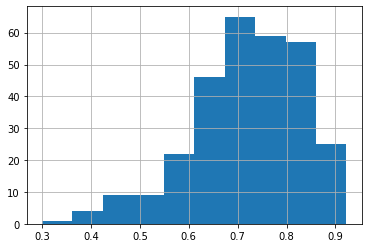

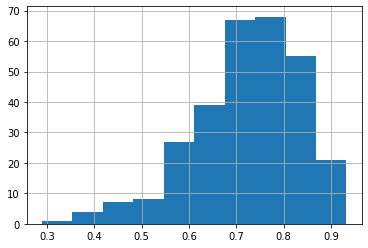

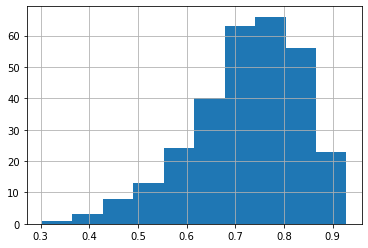

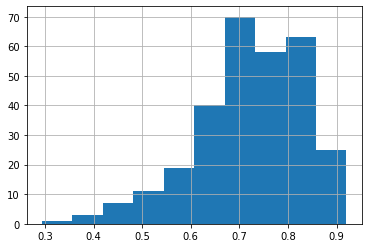

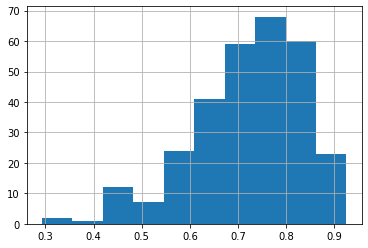

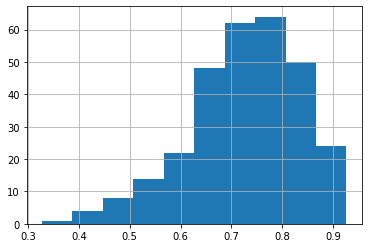

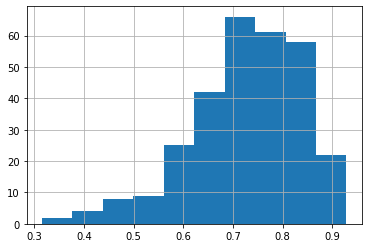

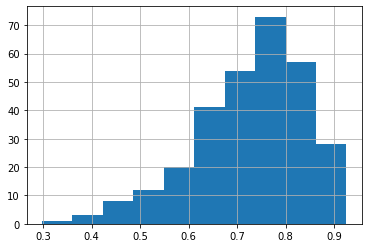

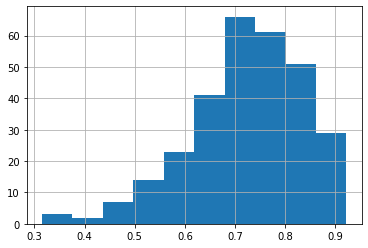

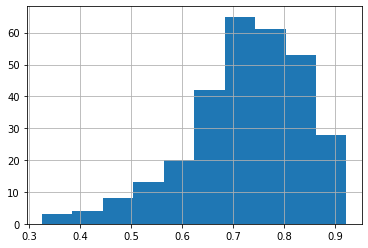

In [11]:
for report in reports:
    report['f1-score'].hist()
    plt.show()

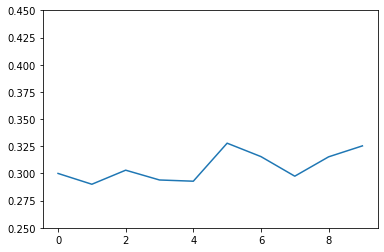

In [12]:
sns.lineplot(y=[report['f1-score'].min() for report in reports], x = range(len(reports)))
plt.ylim((0.25,0.45))
plt.show()

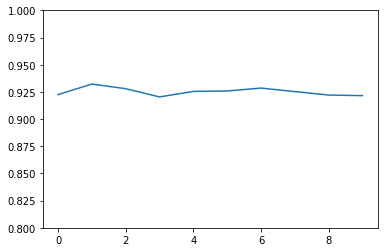

In [13]:
sns.lineplot(y=[report['f1-score'].max() for report in reports], x = range(len(reports)))
plt.ylim((0.8,1))
plt.show()

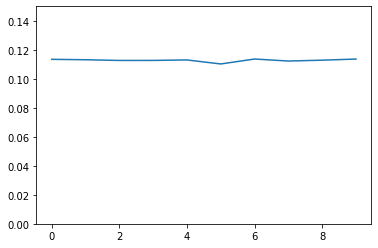

In [14]:
sns.lineplot(y=[report['f1-score'].std() for report in reports], x = range(len(reports)))
plt.ylim((0,0.15))
plt.show()

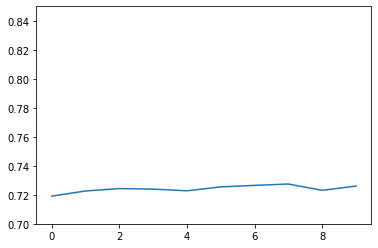

In [15]:
sns.lineplot(y=[report['f1-score'].mean() for report in reports], x = range(len(reports)))
plt.ylim((0.7,0.85))
plt.show()

In [ ]:
sns.lineplot(y=[report['f1-score'].median() for report in reports], x = range(len(reports)))
plt.ylim((0.7,0.85))
plt.show()

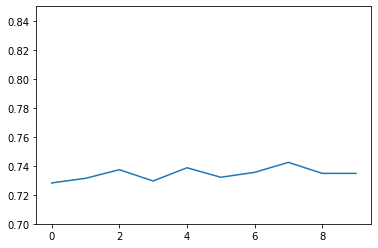

In [16]:
sns.lineplot(y=[report['f1-score'].median() for report in reports], x = range(len(reports)))
plt.ylim((0.7,0.85))
plt.show()